
# Classificação de categoria de jogos da Steam
## Projeto da disciplina SCC0230 - Inteligência Artificial
Membros
Alexandre Eduardo de Souza Jesus - alexandre_souza@usp.br - 12559506

Arthur Santorum Lorenzetto - arts.lorenzetto@usp.br - 12559465

Eduardo Zaffari Monteiro - eduardozaffarimonteiro@usp.br - 12559490(Vice-Líder)

Gustavo Silva de Oliveira - gustavo.oliveira03@usp.br - 12567231 

Lucas Ivars Cadima Ciziks - luciziks@usp.br - 125599472 

Pedro Henrique de Freitas Maçonetto - pedromaconetto@usp.br - 12675419(Líder)

Vitor Okubo Ianella - vitorok.03@gmail.com - 12559451


In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('steam_metadados.csv')

---
## Limpando Dados

In [3]:
# Removendo colunas inúteis
df.drop(columns=['appid','steamspy_tags','platforms','developer',	'publisher','achievements'],inplace=True)

In [4]:
# Removendo Nan(é apenas um jogo)
df.dropna(inplace=True)

In [5]:
# Iremos utilizar classificação apenas para o primeiro gênero
df['genres'] = df['genres'].apply(lambda x: str(x).split(';')[0])

In [6]:
# Total de avaliações de um jogo
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings'] 

In [7]:
# Reestruturando valores de idade mínima
def age_transform(age):
  age = int(age)
  if age == 3 or age == 7:
    return 0
  else:
    return age
  
df['required_age'] = df['required_age'].apply(age_transform)

In [8]:
# Jogo Singleplayer ou Multiplayer
def multi_or_single(cat):
  cat = str(cat).split(';')
  if 'Multi-player' in cat:
    return 1 # Multiplayer
  else:
    return 0 # Singleplayer

df['type']=df['categories'].apply(multi_or_single)
del df['categories']

In [9]:
# Estimativa do número de compradores
def media_comprador(texto):
    txt_min, txt_max = texto.split('-')
    return (int(txt_max) + int(txt_min))/2
    
df['owners'] =  df['owners'].apply(media_comprador)

In [10]:
# Ano de lançamento 
df['year_release'] = df['release_date'].apply(lambda x: str(x).split('-')[0])

---
## DataFrame Limpo:

In [38]:
strat = (df.groupby('genres').count()/df.shape[0])['name']

In [53]:
y.value_counts()

Action                   6037
Adventure                2633
Casual                   1996
Indie                    1329
Violent                   459
Strategy                  400
Simulation                389
RPG                       260
Free to Play              194
Sexual Content            136
Racing                    132
Nudity                     83
Gore                       50
Sports                     49
Animation & Modeling       37
Utilities                  24
Design & Illustration      19
Education                  11
Massively Multiplayer       9
Early Access                7
Audio Production            6
Accounting                  2
Video Production            2
Name: genres, dtype: int64

In [64]:
y_train.value_counts()

Action                   4829
Adventure                2106
Casual                   1597
Indie                    1063
Violent                   367
Strategy                  320
Simulation                311
RPG                       208
Free to Play              155
Sexual Content            109
Racing                    106
Nudity                     66
Gore                       40
Sports                     39
Animation & Modeling       30
Utilities                  19
Design & Illustration      15
Education                   9
Massively Multiplayer       7
Early Access                6
Audio Production            5
Video Production            2
Accounting                  2
Name: genres, dtype: int64

In [50]:
indice = df[ (df['genres'] == 'Software Training') | (df['genres'] == 'Photo Editing') | (df['genres'] == 'Web Publishing')].index
df.drop(indice , inplace=True)

In [11]:
df.head()

,name,release_date,english,required_age,genres,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,type,year_release
0,Counter-Strike,2000-11-01,1,0,Action,124534.0,3339.0,17612.0,317,15000000.0,7.19,127873.0,1,2000
1,Team Fortress Classic,1999-04-01,1,0,Action,3318.0,633.0,277.0,62,7500000.0,3.99,3951.0,1,1999
2,Day of Defeat,2003-05-01,1,0,Action,3416.0,398.0,187.0,34,7500000.0,3.99,3814.0,1,2003
3,Deathmatch Classic,2001-06-01,1,0,Action,1273.0,267.0,258.0,184,7500000.0,3.99,1540.0,1,2001
4,Half-Life: Opposing Force,1999-11-01,1,0,Action,5250.0,288.0,624.0,415,7500000.0,3.99,5538.0,1,1999


---
## Modelo de KNN para os dados:

In [52]:
y = df['genres']
X = df[['english', 'type', 'total_ratings', 'owners', 'price', 'median_playtime', 'year_release']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
n_neighbors = 1

### Scree-plot para definir o K

In [61]:
scores = []
for i in range(1,150,1):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_train, y_train)
  score = neigh.score(X_test,y_test,sample_weight=None)
  scores.append(score)

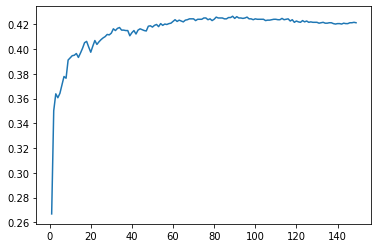

In [62]:
plt.plot(range(1,150,1),scores)

## Modelo de árvore de decisão para os dados:

In [56]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test,y_test,sample_weight=None)

0.31580792148615494

---
Linear Discriminant

In [57]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test,y_test,sample_weight=None)

0.416403785488959

---
SVM

In [58]:
clf = make_pipeline(MinMaxScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test,y_test,sample_weight=None)

0.42481598317560465